## Kaggle European Soccer Database Analysis
### 2. Exploratory Data Analysis - Match Table

The data are downloaded here: [Kaggle European Soccer Database](https://www.kaggle.com/hugomathien/soccer).
### Highlights
* **Home team advantage is confirmed. In both reality and prediction, home team win 46%, draw 25%, lose 29%.**
* **Average number of goals in a match is 2.71, with 1.54 for home team, and 1.16 for away team.**
* **The most popular match score is 1:1, with a percentage of 12%.**
* **Poisson model can be used to predict distributions of number of goals,  match results, and match scores.**

### Table of Contents
#### 2.1 [Match Table Reconstruction](#2.1)
#### 2.2 [League Comparison](#2.2)
#### 2.3 [Top Matches and Teams](#2.3)
#### 2.4 [Poisson Distribution](#2.4)
* 2.4.1 [Predict Goal Occurrence](#2.4.1)
* 2.4.2 [Predict Match Results (home team win/draw/lose percentage)](#2.4.2)
* 2.4.3 [Predict Match Scores](#2.4.3)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
from scipy.stats import poisson  # poisson distribution
from scipy.stats import norm     # normal distribution
from scipy.stats import skellam  # skellam distribution
import pickle
from tqdm import tqdm
import os

sns.set_style('whitegrid')
sns.set_context('notebook')

print('All general modules are imported.')

All general modules are imported.


In [2]:
# Establish connection to sql database

# database file name
db_filename = 'database.sqlite'

# change database file directory as you wish
db_filedir = os.path.join(os.path.pardir, os.path.pardir, os.path.pardir, 'data_source', 'kaggle', db_filename)

try:
    con=sqlite3.connect(db_filedir)
    print('Connection to the database is established.\n')
except Exception as e:
    print('Unable to establish the connection.')

cursor=con.execute("select name from sqlite_master where type='table'")
print('Following Tables are found in the database:')
for i in cursor.fetchall():
    print('{}'.format(i[0]))

Connection to the database is established.

Following Tables are found in the database:
sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


In [3]:
# read player table
try:
    player = pd.read_sql_query('select * from Player',con)
    print('Successfully load player table from the database.')
except Exception as e:
    print('Unable to load player table from the database.')

# read match table
try:
    match = pd.read_sql_query('select * from Match',con)
    print('Successfully load match table from the database.')
except Exception as e:
    print('Unable to load match table from the database.')
    
# read league table
try:
    league=pd.read_sql_query('select * from League',con)
    print('Successfully load league table from the database.')
except Exception as e:
    print('Unable to load league table from the database.')

# read country table
try:
    country=pd.read_sql_query('select * from Country',con)
    print('Successfully load country table from the database.')
except Exception as e:
    print('Unable to load country table from the database.')

# read team table
try:
    team=pd.read_sql_query('select * from Team', con)
    print('Successfully load team table from the database.')
except Exception as e:
    print('Unable to load team table from the database.')

Successfully load player table from the database.
Successfully load match table from the database.
Successfully load league table from the database.
Successfully load country table from the database.
Successfully load team table from the database.


In this section, let's explore match table.

In [4]:
print('The match table has {} columns. The columns are: \n{}\n'.format(match.shape[1], match.columns.values))
print(match.info())
print('\nThe first 2 rows of match table:')
match.head(2)

The match table has 115 columns. The columns are: 
['id' 'country_id' 'league_id' 'season' 'stage' 'date' 'match_api_id'
 'home_team_api_id' 'away_team_api_id' 'home_team_goal' 'away_team_goal'
 'home_player_X1' 'home_player_X2' 'home_player_X3' 'home_player_X4'
 'home_player_X5' 'home_player_X6' 'home_player_X7' 'home_player_X8'
 'home_player_X9' 'home_player_X10' 'home_player_X11' 'away_player_X1'
 'away_player_X2' 'away_player_X3' 'away_player_X4' 'away_player_X5'
 'away_player_X6' 'away_player_X7' 'away_player_X8' 'away_player_X9'
 'away_player_X10' 'away_player_X11' 'home_player_Y1' 'home_player_Y2'
 'home_player_Y3' 'home_player_Y4' 'home_player_Y5' 'home_player_Y6'
 'home_player_Y7' 'home_player_Y8' 'home_player_Y9' 'home_player_Y10'
 'home_player_Y11' 'away_player_Y1' 'away_player_Y2' 'away_player_Y3'
 'away_player_Y4' 'away_player_Y5' 'away_player_Y6' 'away_player_Y7'
 'away_player_Y8' 'away_player_Y9' 'away_player_Y10' 'away_player_Y11'
 'home_player_1' 'home_player_2' 'home_

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


#### 2.1 <a id='2.1'></a>Reconstruct match table with readable information
#### 2.1.1 Substitute contry_id with country name 

In [5]:
# Change column names for country table to be ready for merge to match table
country.columns = ['country_id', 'country']

# Merage the country table to match table
match = pd.merge(match, country, on='country_id', how='left')
print('Successfully merge country table to match table.\n')
print('The first 3 rows of the merged table are:')
match.head(3)

Successfully merge country table to match table.

The first 3 rows of the merged table are:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium


#### 2.1.2 Substitute league_id with league name

In [6]:
# Change column names for league table to be ready for merge to match table
league.columns = ['league_id', 'country_id','league']

# Merage the league table to match table
match = pd.merge(match, league[['league_id','league']], on='league_id', how='left')
print('Sucessfully merge league table to match table.\n')
print('The first 3 rows of the merged table are:')
match.head(3)

Sucessfully merge league table to match table.

The first 3 rows of the merged table are:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country,league
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League


#### 2.1.3 Substitute home_team_api_id with home_team_name

In [7]:
# Create home_team table by copying team table
home_team = team

# Change column names for home_team table to be ready for merge to match table
home_team.columns = ['id','home_team_api_id','home_team_fifa_api_id','home_team','home_team_short_name']

# Merage the home_team table to match table
match = pd.merge(match, home_team[['home_team_api_id','home_team']], on='home_team_api_id', how='left')
print('Successfully merge home_team table to match table.\n')
print('The first 3 rows of the merged table are:')
match.head(3)

Successfully merge home_team table to match table.

The first 3 rows of the merged table are:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country,league,home_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge


#### 2.1.4 Sustitute away_team_api_id with away_team_name

In [8]:
# Create away_team table by copying team table
away_team = team

# Change column names for away_team table to be ready for merge to match table
away_team.columns = ['id','away_team_api_id','away_team_fifa_api_id','away_team','away_team_short_name']

# Merage the home_team table to match table
match = pd.merge(match, away_team[['away_team_api_id','away_team']], on='away_team_api_id', how='left')
print('Successfully merge away_team table to match table.')
print('The first 3 rows of the merged table are:')
match.head(3)

Successfully merge away_team table to match table.
The first 3 rows of the merged table are:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,country,league,home_team,away_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht


Select features for data analysis in this section. And create goal difference and total goal columns.

In [9]:
# Select demand columns
selected_columns=['country', 'league', 'season', 'stage', 'date', 'home_team', 'away_team', 
                  'home_team_goal', 'away_team_goal']

match_goal = match[selected_columns]

for col in ['home_team_goal', 'away_team_goal']:
    match_goal = match_goal[match_goal[col].notnull()]

# Create goal difference column
match_goal['home_team_gd']=match_goal['home_team_goal']-match_goal['away_team_goal']

# Create total goal column
match_goal['total_goal']=match_goal['home_team_goal'] + match_goal['away_team_goal']

In [10]:
match_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 11 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
stage             25979 non-null int64
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
home_team_gd      25979 non-null int64
total_goal        25979 non-null int64
dtypes: int64(5), object(6)
memory usage: 2.4+ MB


#### <a id='2.2'></a>2.2 League comparison

#### 2.2.1 Number of matches

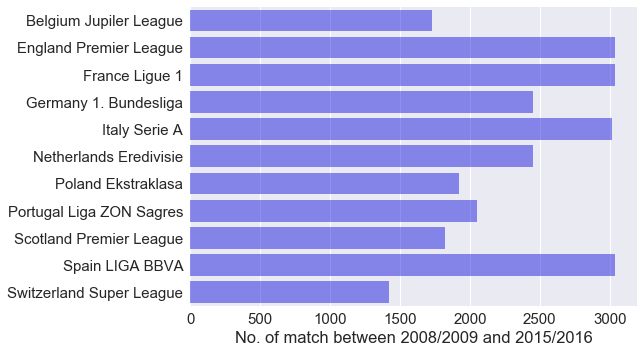

In [11]:
# number of matches for each league in the match table
sns.set(font_scale=1.5)
ax=sns.countplot(y="league", data=match_goal,color='b',alpha=0.5)
plt.ylabel('')
plt.xlabel('No. of match between 2008/2009 and 2015/2016')

In [12]:
print('Number of matches for each league in the match table:')
print(match_goal.groupby(by='league').count()['country'])

Number of matches for each league in the match table:
league
Belgium Jupiler League      1728
England Premier League      3040
France Ligue 1              3040
Germany 1. Bundesliga       2448
Italy Serie A               3017
Netherlands Eredivisie      2448
Poland Ekstraklasa          1920
Portugal Liga ZON Sagres    2052
Scotland Premier League     1824
Spain LIGA BBVA             3040
Switzerland Super League    1422
Name: country, dtype: int64


In [13]:
print('Number of teams for each league each season in the match table:')
print(match_goal.groupby(['league','home_team','season'],as_index=False).count().groupby(['league','season']).count()['home_team'])

Number of teams for each league each season in the match table:
league                    season   
Belgium Jupiler League    2008/2009    18
                          2009/2010    15
                          2010/2011    16
                          2011/2012    16
                          2012/2013    16
                          2013/2014     4
                          2014/2015    16
                          2015/2016    16
England Premier League    2008/2009    20
                          2009/2010    20
                          2010/2011    20
                          2011/2012    20
                          2012/2013    20
                          2013/2014    20
                          2014/2015    20
                          2015/2016    20
France Ligue 1            2008/2009    20
                          2009/2010    20
                          2010/2011    20
                          2011/2012    20
                          2012/2013    20
                  

Summary:
    1. EPL, France and Spain leagues have 3040 matches for each. Each league has 20 teams, so each seaon has 380 matches, and then 8 years will add up to 3040 matches. So no missing games for these 3 leagues from 2008/2009 to 2015/2016.
    2. Italy league has same team number as above 3 leagues but total match number is 3017. So 23 matches were not included.
    3. Germany and Netherlands has 18 teams, add up to 2448 matches. So no missing games for the 2 leagues.
    4. Portugal has all games in tha table.
    5. Other leagues are not verified.

#### 2.2.2 Match goal

In [14]:
print('Some average goal statistics per match for each league:')
match_goal[['league','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('league', as_index=False).mean()

Some average goal statistics per match for each league:


,league,home_team_goal,away_team_goal,total_goal,home_team_gd
0,Belgium Jupiler League,1.609375,1.192130,2.801505,0.417245
1,England Premier League,1.550987,1.159539,2.710526,0.391447
2,France Ligue 1,1.402961,1.040132,2.443092,0.362829
3,Germany 1. Bundesliga,1.626634,1.274918,2.901552,0.351716
4,Italy Serie A,1.500829,1.116009,2.616838,0.384819
5,Netherlands Eredivisie,1.779820,1.301062,3.080882,0.478758
6,Poland Ekstraklasa,1.394792,1.030208,2.425000,0.364583
7,Portugal Liga ZON Sagres,1.408382,1.126218,2.534600,0.282164
8,Scotland Premier League,1.429276,1.204496,2.633772,0.224781
9,Spain LIGA BBVA,1.631250,1.135855,2.767105,0.495395


#### Home team
Netherlands Eredivisie has most home team score rate (1.78 goal/match). Portugal Liga ZON Sagres and France Ligue 1 have least home team score rates (1.40 goal/match).

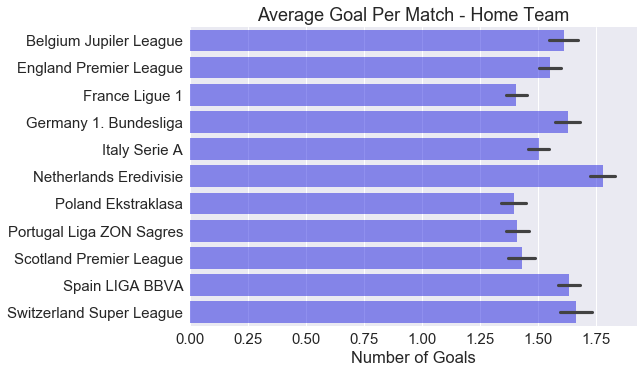

In [15]:
ax=sns.barplot(y="league", x="home_team_goal", color='b',alpha=0.5,data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Home Team')

#### Away team
Netherlands Eredivisie has most away team score rate (1.30 goal/match). Poland Ekstraklasa has least away team score rate (1.03 goal/match). 

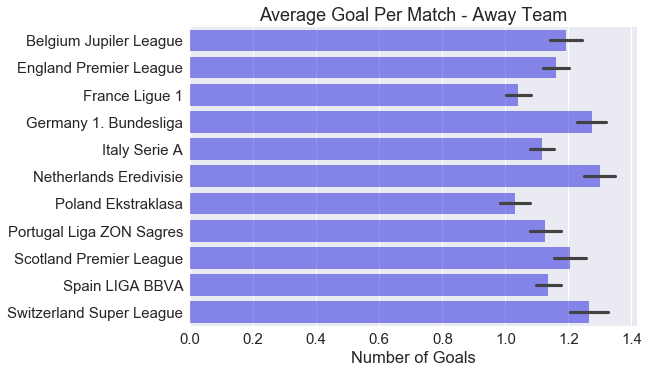

In [16]:
ax=sns.barplot(y="league", x="away_team_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Away Team')

#### Total Goals
Netherlands Eredivisie scores most in each match on average (3.08 goal/match). Poland Ekstraklasa scores least (2.43 goal/match). 

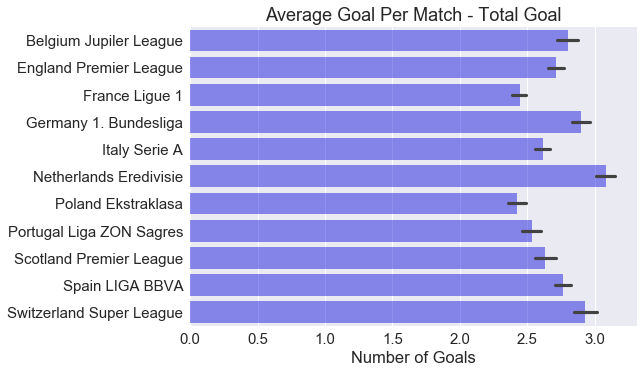

In [17]:
ax=sns.barplot(y="league", x="total_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Total Goal')

#### Goal Difference

    1. Home team scores more than away team in all 11 leagues on average. Home team advantage confirmed.
    2. Spain LIGA BBVA's home team has most home team advantage (with Goal Difference of 0.50).
    3. Scotland Premier League's home team has least home team advantage (with Goal Difference of 0.22).

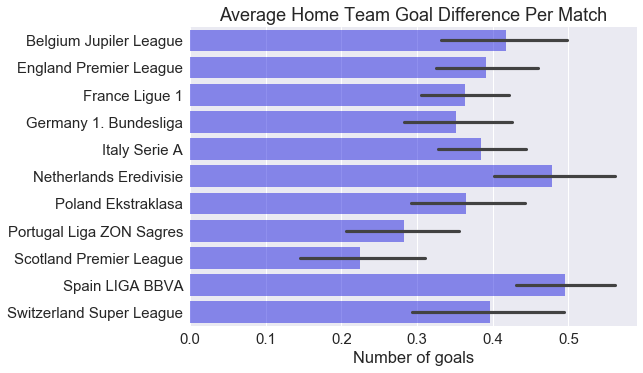

In [18]:
ax=sns.barplot(y="league", x="home_team_gd", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of goals')
plt.title('Average Home Team Goal Difference Per Match')

#### 2.3 <a id='2.3'></a>Top Matches and Teams
#### Top 10 matches: home team scores most

In [19]:
n_top = 10
match_goal.sort_values('home_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
22587,Spain,Spain LIGA BBVA,2010/2011,38,2011-05-21 00:00:00,Real Madrid CF,UD Almería,8,1,7,9
21337,Scotland,Scotland Premier League,2015/2016,17,2016-01-19 00:00:00,Celtic,Hamilton Academical FC,8,1,7,9


#### Top 10 matches: away team scores most

In [20]:
n_top = 10
match_goal.sort_values('away_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
24736,Switzerland,Switzerland Super League,2008/2009,9,2008-09-14 00:00:00,FC Vaduz,FC Zürich,1,7,-6,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
24765,Switzerland,Switzerland Super League,2009/2010,14,2009-10-29 00:00:00,AC Bellinzona,BSC Young Boys,1,7,-6,8


#### Top 10 matches: home team wins with most goal difference

In [21]:
n_top = 10
match_goal.sort_values('home_team_gd',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
22984,Spain,Spain LIGA BBVA,2011/2012,4,2011-09-17 00:00:00,FC Barcelona,CA Osasuna,8,0,8,8
9761,Germany,Germany 1. Bundesliga,2014/2015,21,2015-02-14 00:00:00,FC Bayern Munich,Hamburger SV,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2420,England,England Premier League,2009/2010,38,2010-05-09 00:00:00,Chelsea,Wigan Athletic,8,0,8,8
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8


#### Top 10 matches: away team wins with most goal difference

In [22]:
n_top = 10
match_goal.sort_values('home_team_gd').head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
22949,Spain,Spain LIGA BBVA,2011/2012,36,2012-04-29 00:00:00,Rayo Vallecano,FC Barcelona,0,7,-7,7
9395,Germany,Germany 1. Bundesliga,2013/2014,15,2013-12-07 00:00:00,SV Werder Bremen,FC Bayern Munich,0,7,-7,7
12463,Italy,Italy Serie A,2013/2014,4,2013-09-22 00:00:00,Sassuolo,Inter,0,7,-7,7
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9


#### Top 10 matches: most total goal

In [23]:
n_top = 10
match_goal.sort_values('total_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
3092,England,England Premier League,2011/2012,3,2011-08-28 00:00:00,Manchester United,Arsenal,8,2,6,10
3368,England,England Premier League,2012/2013,20,2012-12-29 00:00:00,Arsenal,Newcastle United,7,3,4,10
23443,Spain,Spain LIGA BBVA,2013/2014,11,2013-10-30 00:00:00,Real Madrid CF,Sevilla FC,7,3,4,10
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
24113,Spain,Spain LIGA BBVA,2014/2015,38,2015-05-23 00:00:00,Real Madrid CF,Getafe CF,7,3,4,10
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10


#### Matches with both teams score more than 4 goals

In [24]:
match_goal[(match_goal['home_team_goal']>4)&(match_goal['away_team_goal']>4)]

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
3565,England,England Premier League,2012/2013,38,2013-05-19 00:00:00,West Bromwich Albion,Manchester United,5,5,0,10
5191,France,France Ligue 1,2009/2010,13,2009-11-08 00:00:00,Olympique Lyonnais,Olympique de Marseille,5,5,0,10
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12


#### Top 10 home teams with best attack

In [25]:
# Average home team goal stats
home_avg_goal = match_goal[['home_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('home_team',as_index=False).mean()

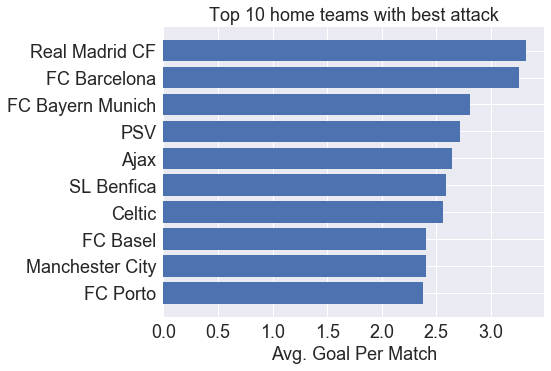

In [26]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_attack = home_avg_goal.sort_values('home_team_goal',ascending=False)[['home_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots()

ax.barh(np.arange(n_top), top_home_team_attack['home_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_attack['home_team'].values, fontsize='medium')
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks(), fontsize='medium')
ax.set_xlabel('Avg. Goal Per Match', fontsize='medium')
ax.set_title('Top {} home teams with best attack'.format(n_top), fontsize='medium')

plt.tight_layout()

#### Top 10 home teams with best defence

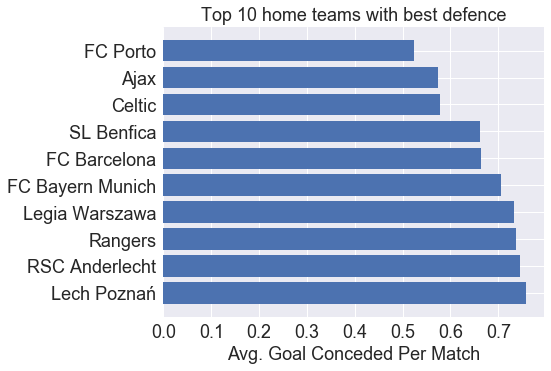

In [27]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_defence = home_avg_goal.sort_values('away_team_goal')[['home_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots()

ax.barh(np.arange(n_top), top_home_team_defence['away_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_defence['home_team'].values, fontsize='medium')
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks(), fontsize='medium')
ax.set_xlabel('Avg. Goal Conceded Per Match', fontsize='medium')
ax.set_title('Top {} home teams with best defence'.format(n_top), fontsize='medium')

plt.tight_layout()

#### Top 10 away teams with best attack

In [28]:
# Average away team stats
away_avg_goal = match_goal[['away_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('away_team',as_index=False).mean()

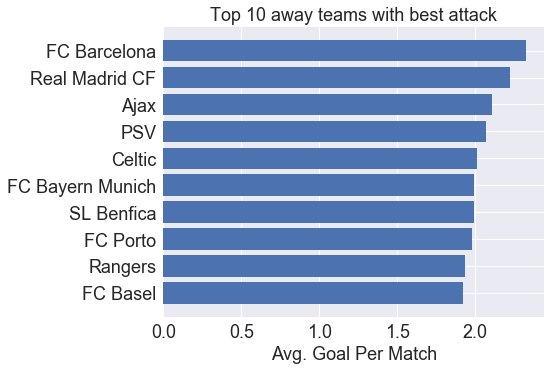

In [29]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_attack = away_avg_goal.sort_values('away_team_goal',ascending=False)[['away_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots()

ax.barh(np.arange(n_top), top_away_team_attack['away_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_attack['away_team'].values, fontsize='medium')
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks(), fontsize='medium')
ax.set_xlabel('Avg. Goal Per Match', fontsize='medium')
ax.set_title('Top {} away teams with best attack'.format(n_top), fontsize='medium')

plt.tight_layout()

#### Top 10 away teams with best defence

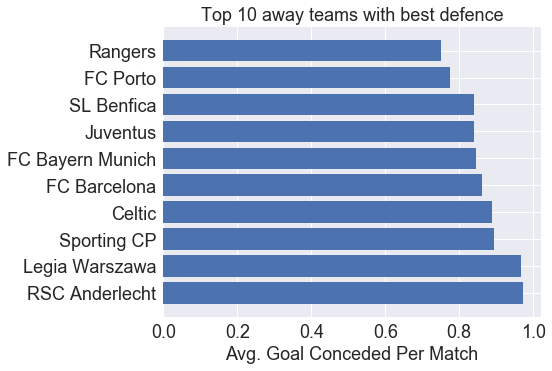

In [30]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_defence = away_avg_goal.sort_values('home_team_goal')[['away_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots()

ax.barh(np.arange(n_top), top_away_team_defence['home_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_defence['away_team'].values, fontsize='medium')
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks(), fontsize='medium')
ax.set_xlabel('Avg. Goal Conceded Per Match', fontsize='medium')
ax.set_title('Top {} away teams with best defence'.format(n_top), fontsize='medium')

plt.tight_layout()

#### <a id='2.4'></a>2.4 Poisson Distribution
$$P(X = k) = \frac{\lambda^ke^{-\lambda}}{k!}, k = 0,1,2,...$$
#### <a id='2.4.1'></a>2.4.1 Predict Goal Occurrence
Goal occurrence follows Poisson distribution.

#### Home team

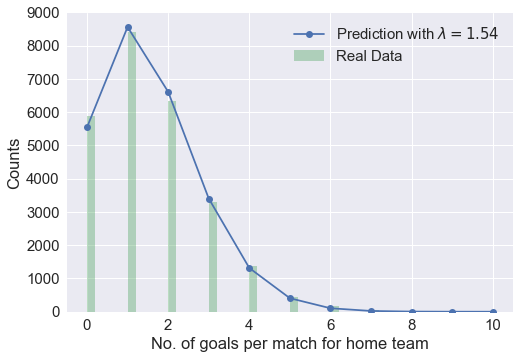

In [31]:
# Estimate lambda for home team goal
lambda_home = match_goal['home_team_goal'].mean()

plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_home)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_home)
ax=sns.distplot(match_goal['home_team_goal'],kde=False, label='Real Data')
plt.xlabel('No. of goals per match for home team')
plt.ylabel('Counts')
plt.legend()

#### Away team

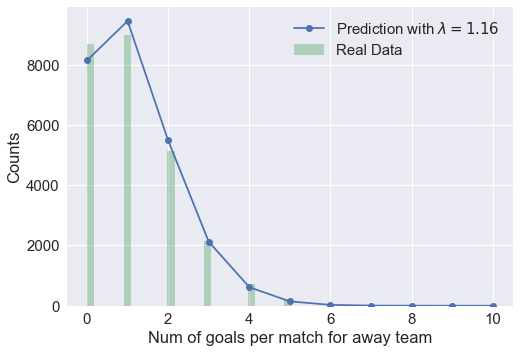

In [32]:
# Estimate lambda for home team goal
lambda_away=match_goal['away_team_goal'].mean()

plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_away)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_away)
ax=sns.distplot(match_goal['away_team_goal'],kde=False, label='Real Data')
plt.xlabel('Num of goals per match for away team')
plt.ylabel('Counts')
plt.legend()

    1. Home team produces more goals on average.
    2. Poisson model fits both very well. So we could say poisson model is good to capture goal occurrence.
    3. Notice that in both cases there is a little bit more zero goals accumulated than prediction. So probably zero-inflated poisson model could be used later.

#### Total Goal
Total goal also follows Poisson distribution. home team goal ~ $\lambda_{home}$, away team goal ~ $\lambda_{away}$, so total goal ~ $\lambda_{home}+\lambda_{away}$[[1]](https://math.stackexchange.com/questions/221078/poisson-distribution-of-sum-of-two-random-independent-variables-x-y).

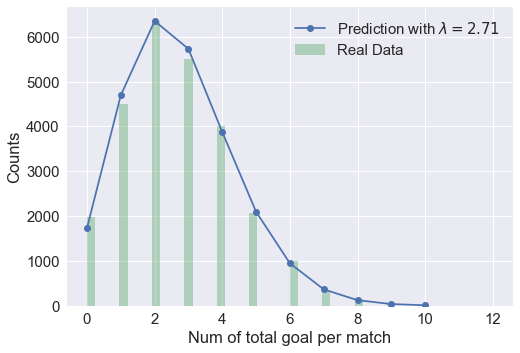

In [33]:
# Estimate lambda for total goal
lambda_total=match_goal['total_goal'].mean()

plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_total)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_total)
ax=sns.distplot(match_goal['total_goal'],kde=False, label='Real Data')
plt.xlabel('Num of total goal per match')
plt.ylabel('Counts')
plt.legend()
#plt.savefig('poisson_match_goal.jpg', dpi=400)

#### Goal Difference

Goal difference follows Skellam distribution [[2]](https://en.wikipedia.org/wiki/Skellam_distribution) [[3]](https://stats.stackexchange.com/questions/47749/how-to-calculate-cumulative-poisson-probabilities-without-adding-each-one-if-no).

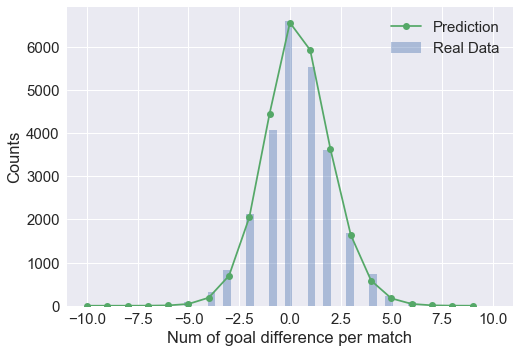

In [34]:
# define goal difference range for plot
gd_range = np.arange(20) - 10   # -10 to 9

sns.distplot(match_goal['home_team_gd'],kde=False, label='Real Data')
plt.plot(gd_range, skellam.pmf(gd_range, lambda_home, lambda_away)*match_goal.shape[0], '-o', label="Prediction")
plt.xlabel('Num of goal difference per match')
plt.ylabel('Counts')
plt.legend()

#### <a id='2.4.2'></a>2.4.2 Predict Match Result (home team win/draw/lose percentage)

In [35]:
# Encode match result
# home team win:  0
# home team draw: 1
# home team lose: 2
match_goal['result'] = np.where(match_goal['home_team_gd'] > 0, 0, np.where(match_goal['home_team_gd'] < 0, 2, 1))

Use Poisson Distribution to add up probability of home team win/draw/lose.

In [36]:
# Use Possion Distribution to predict match result percentage
p_win, p_draw, p_lose = 0, 0, 0

# Maxmium number of goals for a team per match
n_max = 20

# Loop over all possibility of home team goal
for i in np.arange(n_max):
    # Loop over all possibility of away team goal
    for j in np.arange(n_max):
        # home team win
        if i > j:
            p_win = p_win+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # draw
        elif i == j:
            p_draw = p_draw+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # home team lose
        else:
            p_lose = p_lose+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]

# home team win ratio
print('Home Team Win Percentage:       {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('Predicted Home Win Probability: {:.2f}%\n'.format(p_win*100))

# draw ratio
print('Home Team Draw Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('Predicted Draw Probability:     {:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('Home Team Lose Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('Predicted Home Lose Probability:{:.2f}%\n'.format(p_lose*100))

Home Team Win Percentage:       45.87%
Predicted Home Win Probability: 46.16%

Home Team Draw Percentage:      25.39%
Predicted Draw Probability:     25.24%

Home Team Lose Percentage:      28.74%
Predicted Home Lose Probability:28.60%



Alternatively, using Skellam Distribution should give exactly the same result.

In [37]:
# Use Skellam Distribution to predict match result percentage

# n_max: range of goal difference. For example, if n_max = 3, the calcution will add up p(1), p(2) and p(3) for home team win,
# and will add up p(-1), (p-2) and p(-3) for home team lose
n_max = 20

p_win = np.sum(skellam.pmf(np.arange(n_max)+1, lambda_home, lambda_away))
p_draw = np.sum(skellam.pmf(0, lambda_home, lambda_away))
p_lose = np.sum(skellam.pmf(np.arange(n_max)-n_max, lambda_home, lambda_away))

# home team win ratio
print('Home Team Win Percentage:       {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('Predicted Home Win Probability: {:.2f}%\n'.format(p_win*100))

# draw ratio
print('Home Team Draw Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('Predicted Draw Probability:     {:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('Home Team Lose Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('Predicted Home Lose Probability:{:.2f}%\n'.format(p_lose*100))

Home Team Win Percentage:       45.87%
Predicted Home Win Probability: 46.16%

Home Team Draw Percentage:      25.39%
Predicted Draw Probability:     25.24%

Home Team Lose Percentage:      28.74%
Predicted Home Lose Probability:28.60%



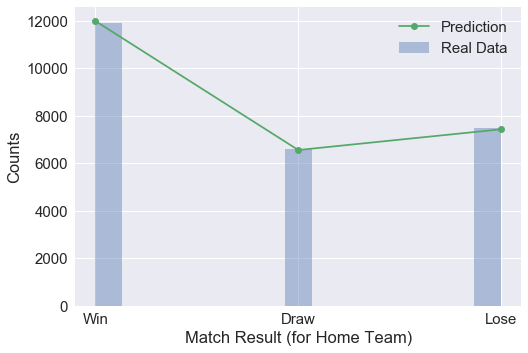

In [38]:
# Plot number of 3 match results against predicted number of 3 match results (home team win/draw/lose)
ax = sns.distplot(match_goal['result'],kde=False, label='Real Data')
plt.plot(np.arange(3), match_goal.shape[0]*np.array([p_win, p_draw, p_lose]), '-o', label="Prediction")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Win', 'Draw', 'Lose'])
plt.xlabel('Match Result (for Home Team)')
plt.ylabel('Counts')
plt.legend()

The numbers of predicted 3 match results matches with actual number of 3 match results very well.

#### <a id='2.4.3'></a>2.4.3 Predict Match Scores

Use Poisson Distribution to predict the probability of a specific match score.

In [39]:
# max goal for each team
max_goal = 4

# The row index is home team score, and the column index is away team score,
# the value is the probability for this match score
# define a matrix to store prediced probability for match scores
match_score_pred = np.zeros((max_goal+1,max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        # Predict with poisson distribution
        match_score_pred[i,j] = poisson.pmf(np.arange(max_goal+1), lambda_home)[i]*poisson.pmf(np.arange(max_goal+1), lambda_away)[j]

# define a matrix to store actual percentage for match scores
match_score = np.zeros((max_goal+1, max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        match_score[i,j] = match_goal[(match_goal['home_team_goal'] == i)&(match_goal['away_team_goal'] == j)].shape[0]/match_goal.shape[0]

In [40]:
print('MATCH SCORE PREDICTION')
print('Match Score | Acutal Percentage | Predicted Probability')
for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        print('{:5.0f}:{}{:15.2f}%{:20.2f}%'.format(i, j, match_score[i,j]*100, match_score_pred[i, j]*100))

MATCH SCORE PREDICTION
Match Score | Acutal Percentage | Predicted Probability
    0:0           7.61%                6.68%
    0:1           7.17%                7.76%
    0:2           4.64%                4.50%
    0:3           2.06%                1.74%
    0:4           0.85%                0.51%
    1:0          10.17%               10.32%
    1:1          11.60%               11.98%
    1:2           6.39%                6.96%
    1:3           2.85%                2.69%
    1:4           0.95%                0.78%
    2:0           8.21%                7.97%
    2:1           8.39%                9.26%
    2:2           5.04%                5.37%
    2:3           1.88%                2.08%
    2:4           0.64%                0.60%
    3:0           4.34%                4.10%
    3:1           4.64%                4.77%
    3:2           2.36%                2.77%
    3:3           1.02%                1.07%
    3:4           0.19%                0.31%
    4:0           2.0

The predicted probabilities of match scores match with real ratios quite well.

#### Top 10 Popular match scores

In [41]:
# Top 10 popular match scores
n_top = 10

print('Top {} Match Scores in Prediction'.format(n_top))
print('Match Score | Probability')

for i in np.arange(n_top):
    home_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][1]
    print('{:5.0f}:{}{:17.2f}%'.format(home_index, away_index, np.partition(match_score_pred.flatten(), -i-1)[-i-1]*100))

print('\nTop {} Match Scores in Reality'.format(n_top))
print('Match Score | Percentage')
for i in np.arange(10):
    home_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][1]
    print('{:5.0f}:{}{:17.2f}%'.format(home_index, away_index, np.partition(match_score.flatten(), -i-1)[-i-1]*100))

Top 10 Match Scores in Prediction
Match Score | Probability
    1:1            11.98%
    1:0            10.32%
    2:1             9.26%
    2:0             7.97%
    0:1             7.76%
    1:2             6.96%
    0:0             6.68%
    2:2             5.37%
    3:1             4.77%
    0:2             4.50%

Top 10 Match Scores in Reality
Match Score | Percentage
    1:1            11.60%
    1:0            10.17%
    2:1             8.39%
    2:0             8.21%
    0:0             7.61%
    0:1             7.17%
    1:2             6.39%
    2:2             5.04%
    3:1             4.64%
    0:2             4.64%
